In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyclifford as pc
import gymnasium as gym
import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

In [2]:
import pyclifford as pc
from pyclifford.utils import mask, condense, pauli_diagonalize1,stabilizer_measure
from pyclifford.paulialg import Pauli, pauli, PauliMonomial, pauli_zero
from pyclifford.stabilizer import (StabilizerState, CliffordMap,
    zero_state, identity_map, clifford_rotation_map, random_clifford_map)

In [3]:
def random_layers(N_QUBITS,HALF_DEPTH):
    random_layers=[]
    for i in range (int(HALF_DEPTH)):
        random_layer=[]
        if i%2==0:
            for j in range (int(np.floor(N_QUBITS/2))):
                gate=pc.CliffordGate(j*2,j*2+1)
                gate.set_forward_map(pc.random_clifford_map(2))
                random_layer.append(gate)
            random_layers.append(random_layer)
        elif i%2==1:
            for j in range (int(np.floor(N_QUBITS/2))):
                gate=pc.CliffordGate(j*2+1,(j*2+2)%N_QUBITS)
                gate.set_forward_map(pc.random_clifford_map(2))
                random_layer.append(gate)
            random_layers.append(random_layer)
    return random_layers

In [4]:
def measure_layers(N_QUBITS,HALF_DEPTH,theta):
    measure_layers=[]
    for i in range (int(HALF_DEPTH)):
        measure_layer=[]
        for j in range (int(N_QUBITS)):
            if theta[-i + HALF_DEPTH - 1][j]==1:
                measure_layer.append(j)
        measure_layers.append(measure_layer)
    return measure_layers

In [5]:
def create_circuit(N_QUBITS,HALF_DEPTH,random_layers,measure_layers):
    circ = pc.circuit.Circuit(N_QUBITS)
    for i in range(int(HALF_DEPTH)):
        for j in range(int(np.floor(N_QUBITS/2))):
            circ.take(random_layers[i][j])
        if measure_layers[i]!=[]:
            qubits=tuple(measure_layers[i])
            circ.measure(*qubits)
            
    return circ

In [6]:
def averaged_EE(state_final):
    EE_positions=[]
    for i in range(0,state_final.N):
        EE_positions.append([int(i),int(i+1)%state_final.N])
        
    EE_list=[]
    for i in range(0,len(EE_positions)):
        EE_list.append(state_final.entropy(EE_positions[i]))
    
    averaged_EE=np.mean(EE_list)
        
    return averaged_EE #, EE_positions, EE_list

In [7]:
def penalty(x,penalty_slope):
    return 2*(0.5-(1/(1+np.exp(-penalty_slope*x))-0.5))

In [8]:
class Disentangler(gym.Env):
    """
    Reinforcement learning environment for the disentangler.
    """
    
    def __init__(self, n_qubits, half_depth, positive_reward, penalty_slope):
        super(Disentangler, self).__init__()
        
        self.N_QUBITS = n_qubits
        self.HALF_DEPTH = half_depth
        self.DEPTH = 2*half_depth
        self.positive_reward = positive_reward
        self.penalty_slope = penalty_slope
        
        self.action_space = gym.spaces.Discrete(self.N_QUBITS * self.HALF_DEPTH)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(self.HALF_DEPTH, self.N_QUBITS), dtype=np.int8)

        self.random_layers=random_layers(self.N_QUBITS,self.HALF_DEPTH)
        self.theta = np.zeros((self.HALF_DEPTH, self.N_QUBITS), dtype=np.int8)
        self.measure_layers=measure_layers(self.N_QUBITS,self.HALF_DEPTH,self.theta)
        
    def step(self, action):
        # Initialize reward and done
        reward = 0
        done = False
        truncate = False

        # Apply the action
        h = np.zeros(self.N_QUBITS * self.HALF_DEPTH, dtype=np.int8)
        h[action] = 1
        h = h.reshape((self.HALF_DEPTH, self.N_QUBITS))
        self.theta = (self.theta + h) % 2

        # Calculate entropy (assumes circuit is a predefined function)
        self.measure_layers=measure_layers(self.N_QUBITS, self.HALF_DEPTH, self.theta)
        circ = create_circuit(self.N_QUBITS, self.HALF_DEPTH, self.random_layers, self.measure_layers)

        state_initial = pc.stabilizer.zero_state(self.N_QUBITS)
        state_final = circ.forward(state_initial)

        entropy = averaged_EE(state_final)

        
        if entropy == 0:
            m_per_layer = [np.sum(layer) for layer in self.theta]
            cost = [m_per_layer[i]*penalty(i,self.penalty_slope) for i in range(self.HALF_DEPTH)]
            reward = self.positive_reward - np.sum(cost)#/(self.N_QUBITS*self.DEPTH)
            done = True
        
        # Return the state, reward, done flag, truncate flag, and info
        info = {}
        return self.theta, reward, done, truncate, info
    
    def return_entropy(self):
        # Calculate entropy (assumes circuit is a predefined function)
        self.measure_layers=measure_layers(self.N_QUBITS, self.HALF_DEPTH, self.theta)
        circ = create_circuit(self.N_QUBITS, self.HALF_DEPTH, self.random_layers, self.measure_layers)

        state_initial = pc.stabilizer.zero_state(self.N_QUBITS)
        state_final = circ.forward(state_initial)

        entropy = averaged_EE(state_final)
        
        return entropy
        
    
    def reset(self, seed=None):
        # Seed the random number generator if a seed is provided
        if seed is not None:
            np.random.seed(seed)
        
        # Reset the state to an all-zero matrix
        self.theta = np.zeros((self.HALF_DEPTH, self.N_QUBITS), dtype=np.int8)

        # Reset the random layers to another random layers
        self.random_layers=random_layers(self.N_QUBITS,self.HALF_DEPTH)
        
        info = {}
        return self.theta, info
    
    def render(self):
        print()

    def close(self):
        # Optional: Implement any cleanup
        pass


In [66]:
# ppo parameters
ts = 0.5*1e6
lr = 0.001
ec = 0.01
#ec_list=[0.01,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5]

# circuit parameters
#N_QUBITS=2
N_QUBITS_list=[2,3,4,5,6,7,8,9,10]#,15,20,25,30]

#HALF_DEPTH=2
#DEPTH=int(2*HALF_DEPTH)
HALF_DEPTH_list=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]#,25,30]
DEPTH_list=[int(2*HALF_DEPTH_list[i]) for i in range(np.size(HALF_DEPTH_list))]

positive_reward = 50
penalty_slope = 0#[0,0.5,1,2,3,4,5]

#num_full_learning = 1

In [67]:
#Evaluating the model

rewards_list =  [[[] for j in range(np.size(HALF_DEPTH_list))]for j in range(np.size(N_QUBITS_list))]
measurements_list = [[[] for j in range(np.size(HALF_DEPTH_list))]for j in range(np.size(N_QUBITS_list))]
num_measurements_list = [[[] for j in range(np.size(HALF_DEPTH_list))]for j in range(np.size(N_QUBITS_list))]

avg_rewards_over_ep=[[] for i in range(np.size(N_QUBITS_list))]
avg_lens_per_ep_over_ep=[[] for i in range(np.size(N_QUBITS_list))]


for i in range(np.size(N_QUBITS_list)):
    print("evaluation of N_QUBITS",'=', N_QUBITS_list[i])
    N_QUBITS=N_QUBITS_list[i]
    
    for j in range(np.size(HALF_DEPTH_list)):
        print("evaluation of HALF_DEPTH",'=',HALF_DEPTH_list[j])
        HALF_DEPTH= HALF_DEPTH_list[j]
        
        env = Disentangler(N_QUBITS,HALF_DEPTH,positive_reward,penalty_slope)
        
        model_path="./models/{N_QUBITS}x{HALF_DEPTH}_tb_{ts}_pr_{positive_reward}_ps_{penalty_slope}".format(N_QUBITS=N_QUBITS, HALF_DEPTH=HALF_DEPTH, ts=ts, positive_reward=positive_reward, penalty_slope=penalty_slope)
        model = PPO.load(model_path)
        
        
#    rewards, lengths = evaluate_policy(model, env, n_eval_episodes=1000, return_episode_rewards=True, warn=False)
        episodes = 100
        for _ in range(episodes):
            print("episode",'=', _)
            obs, _ = env.reset()
            done = False
    
            while not done:
                action, state = model.predict(obs)
                obs, rewards, done, truncate, info = env.step(action)

            rewards_list[i][j].append(rewards)
            measurements_list[i][j].append(obs)
            num_measurements_list[i][j].append(np.sum(obs))
        
        avg_rewards_over_ep[i].append(np.mean(rewards_list[i][j]))
        avg_lens_per_ep_over_ep[i].append(np.mean(num_measurements_list[i][j]))
    

evaluation of N_QUBITS = 2
evaluation of HALF_DEPTH = 2
episode = 0
episode = 1
episode = 2
episode = 3
episode = 4
episode = 5
episode = 6
episode = 7
episode = 8
episode = 9
episode = 10
episode = 11
episode = 12
episode = 13
episode = 14
episode = 15
episode = 16
episode = 17
episode = 18
episode = 19
episode = 20
episode = 21
episode = 22
episode = 23
episode = 24
episode = 25
episode = 26
episode = 27
episode = 28
episode = 29
episode = 30
episode = 31
episode = 32
episode = 33
episode = 34
episode = 35
episode = 36
episode = 37
episode = 38
episode = 39
episode = 40
episode = 41
episode = 42
episode = 43
episode = 44
episode = 45
episode = 46
episode = 47
episode = 48
episode = 49
episode = 50
episode = 51
episode = 52
episode = 53
episode = 54
episode = 55
episode = 56
episode = 57
episode = 58
episode = 59
episode = 60
episode = 61
episode = 62
episode = 63
episode = 64
episode = 65
episode = 66
episode = 67
episode = 68
episode = 69
episode = 70
episode = 71
episode = 72
episo

episode = 45
episode = 46
episode = 47
episode = 48
episode = 49
episode = 50
episode = 51
episode = 52
episode = 53
episode = 54
episode = 55
episode = 56
episode = 57
episode = 58
episode = 59
episode = 60
episode = 61
episode = 62
episode = 63
episode = 64
episode = 65
episode = 66
episode = 67
episode = 68
episode = 69
episode = 70
episode = 71
episode = 72
episode = 73
episode = 74
episode = 75
episode = 76
episode = 77
episode = 78
episode = 79
episode = 80
episode = 81
episode = 82
episode = 83
episode = 84
episode = 85
episode = 86
episode = 87
episode = 88
episode = 89
episode = 90
episode = 91
episode = 92
episode = 93
episode = 94
episode = 95
episode = 96
episode = 97
episode = 98
episode = 99
evaluation of HALF_DEPTH = 9
episode = 0
episode = 1
episode = 2
episode = 3
episode = 4
episode = 5
episode = 6
episode = 7
episode = 8
episode = 9
episode = 10
episode = 11
episode = 12
episode = 13
episode = 14
episode = 15
episode = 16
episode = 17
episode = 18
episode = 19
episod

episode = 78
episode = 79
episode = 80
episode = 81
episode = 82
episode = 83
episode = 84
episode = 85
episode = 86
episode = 87
episode = 88
episode = 89
episode = 90
episode = 91
episode = 92
episode = 93
episode = 94
episode = 95
episode = 96
episode = 97
episode = 98
episode = 99
evaluation of HALF_DEPTH = 8
episode = 0
episode = 1
episode = 2
episode = 3
episode = 4
episode = 5
episode = 6
episode = 7
episode = 8
episode = 9
episode = 10
episode = 11
episode = 12
episode = 13
episode = 14
episode = 15
episode = 16
episode = 17
episode = 18
episode = 19
episode = 20
episode = 21
episode = 22
episode = 23
episode = 24
episode = 25
episode = 26
episode = 27
episode = 28
episode = 29
episode = 30
episode = 31
episode = 32
episode = 33
episode = 34
episode = 35
episode = 36
episode = 37
episode = 38
episode = 39
episode = 40
episode = 41
episode = 42
episode = 43
episode = 44
episode = 45
episode = 46
episode = 47
episode = 48
episode = 49
episode = 50
episode = 51
episode = 52
episod

episode = 99
evaluation of HALF_DEPTH = 4
episode = 0
episode = 1
episode = 2
episode = 3
episode = 4
episode = 5
episode = 6
episode = 7
episode = 8
episode = 9
episode = 10
episode = 11
episode = 12
episode = 13
episode = 14
episode = 15
episode = 16
episode = 17
episode = 18
episode = 19
episode = 20
episode = 21
episode = 22
episode = 23
episode = 24
episode = 25
episode = 26
episode = 27
episode = 28
episode = 29
episode = 30
episode = 31
episode = 32
episode = 33
episode = 34
episode = 35
episode = 36
episode = 37
episode = 38
episode = 39
episode = 40
episode = 41
episode = 42
episode = 43
episode = 44
episode = 45
episode = 46
episode = 47
episode = 48
episode = 49
episode = 50
episode = 51
episode = 52
episode = 53
episode = 54
episode = 55
episode = 56
episode = 57
episode = 58
episode = 59
episode = 60
episode = 61
episode = 62
episode = 63
episode = 64
episode = 65
episode = 66
episode = 67
episode = 68
episode = 69
episode = 70
episode = 71
episode = 72
episode = 73
episod

episode = 20
episode = 21
episode = 22
episode = 23
episode = 24
episode = 25
episode = 26
episode = 27
episode = 28
episode = 29
episode = 30
episode = 31
episode = 32
episode = 33
episode = 34
episode = 35
episode = 36
episode = 37
episode = 38
episode = 39
episode = 40
episode = 41
episode = 42
episode = 43
episode = 44
episode = 45
episode = 46
episode = 47
episode = 48
episode = 49
episode = 50
episode = 51
episode = 52
episode = 53
episode = 54
episode = 55
episode = 56
episode = 57
episode = 58
episode = 59
episode = 60
episode = 61
episode = 62
episode = 63
episode = 64
episode = 65
episode = 66
episode = 67
episode = 68
episode = 69
episode = 70
episode = 71
episode = 72
episode = 73
episode = 74
episode = 75
episode = 76
episode = 77
episode = 78
episode = 79
episode = 80
episode = 81
episode = 82
episode = 83
episode = 84
episode = 85
episode = 86
episode = 87
episode = 88
episode = 89
episode = 90
episode = 91
episode = 92
episode = 93
episode = 94
episode = 95
episode = 96

episode = 41
episode = 42
episode = 43
episode = 44
episode = 45
episode = 46
episode = 47
episode = 48
episode = 49
episode = 50
episode = 51
episode = 52
episode = 53
episode = 54
episode = 55
episode = 56
episode = 57
episode = 58
episode = 59
episode = 60
episode = 61
episode = 62
episode = 63
episode = 64
episode = 65
episode = 66
episode = 67
episode = 68
episode = 69
episode = 70
episode = 71
episode = 72
episode = 73
episode = 74
episode = 75
episode = 76
episode = 77
episode = 78
episode = 79
episode = 80
episode = 81
episode = 82
episode = 83
episode = 84
episode = 85
episode = 86
episode = 87
episode = 88
episode = 89
episode = 90
episode = 91
episode = 92
episode = 93
episode = 94
episode = 95
episode = 96
episode = 97
episode = 98
episode = 99
evaluation of HALF_DEPTH = 7
episode = 0
episode = 1
episode = 2
episode = 3
episode = 4
episode = 5
episode = 6
episode = 7
episode = 8
episode = 9
episode = 10
episode = 11
episode = 12
episode = 13
episode = 14
episode = 15
episod

episode = 17
episode = 18
episode = 19
episode = 20
episode = 21
episode = 22
episode = 23
episode = 24
episode = 25
episode = 26
episode = 27
episode = 28
episode = 29
episode = 30
episode = 31
episode = 32
episode = 33
episode = 34
episode = 35
episode = 36
episode = 37
episode = 38
episode = 39
episode = 40
episode = 41
episode = 42
episode = 43
episode = 44
episode = 45
episode = 46
episode = 47
episode = 48
episode = 49
episode = 50
episode = 51
episode = 52
episode = 53
episode = 54
episode = 55
episode = 56
episode = 57
episode = 58
episode = 59
episode = 60
episode = 61
episode = 62
episode = 63
episode = 64
episode = 65
episode = 66
episode = 67
episode = 68
episode = 69
episode = 70
episode = 71
episode = 72
episode = 73
episode = 74
episode = 75
episode = 76
episode = 77
episode = 78
episode = 79
episode = 80
episode = 81
episode = 82
episode = 83
episode = 84
episode = 85
episode = 86
episode = 87
episode = 88
episode = 89
episode = 90
episode = 91
episode = 92
episode = 93

episode = 90
episode = 91
episode = 92
episode = 93
episode = 94
episode = 95
episode = 96
episode = 97
episode = 98
episode = 99
evaluation of HALF_DEPTH = 10
episode = 0
episode = 1
episode = 2
episode = 3
episode = 4
episode = 5
episode = 6
episode = 7
episode = 8
episode = 9
episode = 10
episode = 11
episode = 12
episode = 13
episode = 14
episode = 15
episode = 16
episode = 17
episode = 18
episode = 19
episode = 20
episode = 21
episode = 22
episode = 23
episode = 24
episode = 25
episode = 26
episode = 27
episode = 28
episode = 29
episode = 30
episode = 31
episode = 32
episode = 33
episode = 34
episode = 35
episode = 36
episode = 37
episode = 38
episode = 39
episode = 40
episode = 41
episode = 42
episode = 43
episode = 44
episode = 45
episode = 46
episode = 47
episode = 48
episode = 49
episode = 50
episode = 51
episode = 52
episode = 53
episode = 54
episode = 55
episode = 56
episode = 57
episode = 58
episode = 59
episode = 60
episode = 61
episode = 62
episode = 63
episode = 64
episo

episode = 56
episode = 57
episode = 58
episode = 59
episode = 60
episode = 61
episode = 62
episode = 63
episode = 64
episode = 65
episode = 66
episode = 67
episode = 68
episode = 69
episode = 70
episode = 71
episode = 72
episode = 73
episode = 74
episode = 75
episode = 76
episode = 77
episode = 78
episode = 79
episode = 80
episode = 81
episode = 82
episode = 83
episode = 84
episode = 85
episode = 86
episode = 87
episode = 88
episode = 89
episode = 90
episode = 91
episode = 92
episode = 93
episode = 94
episode = 95
episode = 96
episode = 97
episode = 98
episode = 99
evaluation of HALF_DEPTH = 6
episode = 0
episode = 1
episode = 2
episode = 3
episode = 4
episode = 5
episode = 6
episode = 7
episode = 8
episode = 9
episode = 10
episode = 11
episode = 12
episode = 13
episode = 14
episode = 15
episode = 16
episode = 17
episode = 18
episode = 19
episode = 20
episode = 21
episode = 22
episode = 23
episode = 24
episode = 25
episode = 26
episode = 27
episode = 28
episode = 29
episode = 30
episod

episode = 92
episode = 93
episode = 94
episode = 95
episode = 96
episode = 97
episode = 98
episode = 99
evaluation of HALF_DEPTH = 20
episode = 0
episode = 1
episode = 2
episode = 3
episode = 4
episode = 5
episode = 6
episode = 7
episode = 8
episode = 9
episode = 10
episode = 11
episode = 12
episode = 13
episode = 14
episode = 15
episode = 16
episode = 17
episode = 18
episode = 19
episode = 20
episode = 21
episode = 22
episode = 23
episode = 24
episode = 25
episode = 26
episode = 27
episode = 28
episode = 29
episode = 30
episode = 31
episode = 32
episode = 33
episode = 34
episode = 35
episode = 36
episode = 37
episode = 38
episode = 39
episode = 40
episode = 41
episode = 42
episode = 43
episode = 44
episode = 45
episode = 46
episode = 47
episode = 48
episode = 49
episode = 50
episode = 51
episode = 52
episode = 53
episode = 54
episode = 55
episode = 56
episode = 57
episode = 58
episode = 59
episode = 60
episode = 61
episode = 62
episode = 63
episode = 64
episode = 65
episode = 66
episo

episode = 24
episode = 25
episode = 26
episode = 27
episode = 28
episode = 29
episode = 30
episode = 31
episode = 32
episode = 33
episode = 34
episode = 35
episode = 36
episode = 37
episode = 38
episode = 39
episode = 40
episode = 41
episode = 42
episode = 43
episode = 44
episode = 45
episode = 46
episode = 47
episode = 48
episode = 49
episode = 50
episode = 51
episode = 52
episode = 53
episode = 54
episode = 55
episode = 56
episode = 57
episode = 58
episode = 59
episode = 60
episode = 61
episode = 62
episode = 63
episode = 64
episode = 65
episode = 66
episode = 67
episode = 68
episode = 69
episode = 70
episode = 71
episode = 72
episode = 73
episode = 74
episode = 75
episode = 76
episode = 77
episode = 78
episode = 79
episode = 80
episode = 81
episode = 82
episode = 83
episode = 84
episode = 85
episode = 86
episode = 87
episode = 88
episode = 89
episode = 90
episode = 91
episode = 92
episode = 93
episode = 94
episode = 95
episode = 96
episode = 97
episode = 98
episode = 99
evaluation o

episode = 36
episode = 37
episode = 38
episode = 39
episode = 40
episode = 41
episode = 42
episode = 43
episode = 44
episode = 45
episode = 46
episode = 47
episode = 48
episode = 49
episode = 50
episode = 51
episode = 52
episode = 53
episode = 54
episode = 55
episode = 56
episode = 57
episode = 58
episode = 59
episode = 60
episode = 61
episode = 62
episode = 63
episode = 64
episode = 65
episode = 66
episode = 67
episode = 68
episode = 69
episode = 70
episode = 71
episode = 72
episode = 73
episode = 74
episode = 75
episode = 76
episode = 77
episode = 78
episode = 79
episode = 80
episode = 81
episode = 82
episode = 83
episode = 84
episode = 85
episode = 86
episode = 87
episode = 88
episode = 89
episode = 90
episode = 91
episode = 92
episode = 93
episode = 94
episode = 95
episode = 96
episode = 97
episode = 98
episode = 99
evaluation of HALF_DEPTH = 4
episode = 0
episode = 1
episode = 2
episode = 3
episode = 4
episode = 5
episode = 6
episode = 7
episode = 8
episode = 9
episode = 10
episod

episode = 59
episode = 60
episode = 61
episode = 62
episode = 63
episode = 64
episode = 65
episode = 66
episode = 67
episode = 68
episode = 69
episode = 70
episode = 71
episode = 72
episode = 73
episode = 74
episode = 75
episode = 76
episode = 77
episode = 78
episode = 79
episode = 80
episode = 81
episode = 82
episode = 83
episode = 84
episode = 85
episode = 86
episode = 87
episode = 88
episode = 89
episode = 90
episode = 91
episode = 92
episode = 93
episode = 94
episode = 95
episode = 96
episode = 97
episode = 98
episode = 99
evaluation of HALF_DEPTH = 10
episode = 0
episode = 1
episode = 2
episode = 3
episode = 4
episode = 5
episode = 6
episode = 7
episode = 8
episode = 9
episode = 10
episode = 11
episode = 12
episode = 13
episode = 14
episode = 15
episode = 16
episode = 17
episode = 18
episode = 19
episode = 20
episode = 21
episode = 22
episode = 23
episode = 24
episode = 25
episode = 26
episode = 27
episode = 28
episode = 29
episode = 30
episode = 31
episode = 32
episode = 33
episo

episode = 22
episode = 23
episode = 24
episode = 25
episode = 26
episode = 27
episode = 28
episode = 29
episode = 30
episode = 31
episode = 32
episode = 33
episode = 34
episode = 35
episode = 36
episode = 37
episode = 38
episode = 39
episode = 40
episode = 41
episode = 42
episode = 43
episode = 44
episode = 45
episode = 46
episode = 47
episode = 48
episode = 49
episode = 50
episode = 51
episode = 52
episode = 53
episode = 54
episode = 55
episode = 56
episode = 57
episode = 58
episode = 59
episode = 60
episode = 61
episode = 62
episode = 63
episode = 64
episode = 65
episode = 66
episode = 67
episode = 68
episode = 69
episode = 70
episode = 71
episode = 72
episode = 73
episode = 74
episode = 75
episode = 76
episode = 77
episode = 78
episode = 79
episode = 80
episode = 81
episode = 82
episode = 83
episode = 84
episode = 85
episode = 86
episode = 87
episode = 88
episode = 89
episode = 90
episode = 91
episode = 92
episode = 93
episode = 94
episode = 95
episode = 96
episode = 97
episode = 98

episode = 58
episode = 59
episode = 60
episode = 61
episode = 62
episode = 63
episode = 64
episode = 65
episode = 66
episode = 67
episode = 68
episode = 69
episode = 70
episode = 71
episode = 72
episode = 73
episode = 74
episode = 75
episode = 76
episode = 77
episode = 78
episode = 79
episode = 80
episode = 81
episode = 82
episode = 83
episode = 84
episode = 85
episode = 86
episode = 87
episode = 88
episode = 89
episode = 90
episode = 91
episode = 92
episode = 93
episode = 94
episode = 95
episode = 96
episode = 97
episode = 98
episode = 99
evaluation of HALF_DEPTH = 20
episode = 0
episode = 1
episode = 2
episode = 3
episode = 4
episode = 5
episode = 6
episode = 7
episode = 8
episode = 9
episode = 10
episode = 11
episode = 12
episode = 13
episode = 14
episode = 15
episode = 16
episode = 17
episode = 18
episode = 19
episode = 20
episode = 21
episode = 22
episode = 23
episode = 24
episode = 25
episode = 26
episode = 27
episode = 28
episode = 29
episode = 30
episode = 31
episode = 32
episo

In [68]:
store rewards_list

Stored 'rewards_list' (list)


In [69]:
store measurements_list

Stored 'measurements_list' (list)


In [70]:
store num_measurements_list

Stored 'num_measurements_list' (list)


In [71]:
store avg_rewards_over_ep

Stored 'avg_rewards_over_ep' (list)


In [72]:
store avg_lens_per_ep_over_ep

Stored 'avg_lens_per_ep_over_ep' (list)


In [ ]:
%store -r rewards_list

In [ ]:
%store -r measurements_list

In [32]:
%store -r num_measurements_list

In [33]:
%store -r avg_rewards_over_ep

In [34]:
%store -r avg_lens_per_ep_over_ep

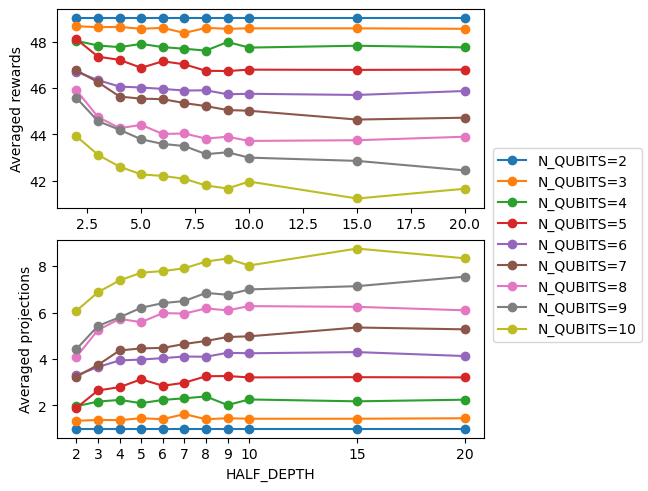

In [118]:
#x_axis = [i+1 for i in range(num_full_learning)], np.size(all_avg_rews)
#have the different learning, put avg_all and variance_all(np.var())

x1_axis = [int(i) for i in HALF_DEPTH_list]
        
fig, axs = plt.subplot_mosaic([['top'],['bottom']],layout='constrained')
    
for i in range(np.size(N_QUBITS_list)):
    N_QUBITS = N_QUBITS_list[i]
    axs['top'].plot(x1_axis,avg_rewards_over_ep[i],linestyle='-', marker='o')
axs['top'].set_ylabel('Averaged rewards')
plt.xticks(x1_axis, x1_axis)


for i in range(np.size(N_QUBITS_list)):
    N_QUBITS = N_QUBITS_list[i]
    axs['bottom'].plot(x1_axis,avg_lens_per_ep_over_ep[i],label="N_QUBITS={N_QUBITS}".format(N_QUBITS=N_QUBITS),linestyle='-', marker='o')
plt.xlabel('HALF_DEPTH')
plt.ylabel('Averaged projections')
plt.xticks(x1_axis, x1_axis)

fig.legend(loc='outside right')

plt.show()

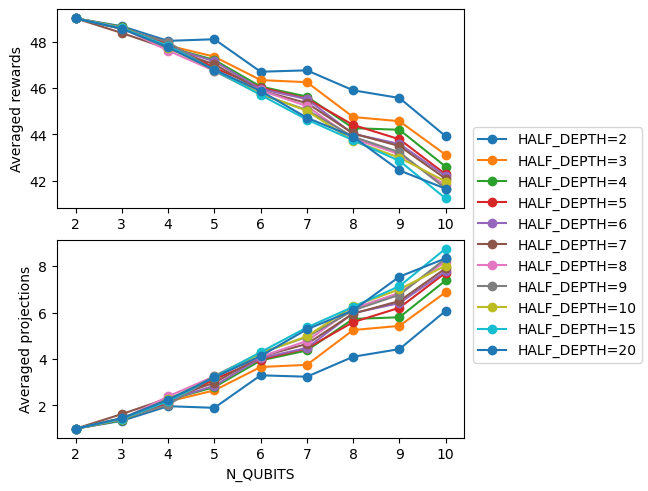

In [119]:
#x_axis = [i+1 for i in range(num_full_learning)], np.size(all_avg_rews)
#have the different learning, put avg_all and variance_all(np.var())

x2_axis = [int(i) for i in N_QUBITS_list]

avg_rewards_over_ep_N_QUBITS=np.transpose(avg_rewards_over_ep)
avg_lens_per_ep_over_ep_N_QUBITS=np.transpose(avg_lens_per_ep_over_ep)

        
fig, axs = plt.subplot_mosaic([['top'],['bottom']],layout='constrained')
    

for i in range(np.size(HALF_DEPTH_list)):
    HALF_DEPTH = HALF_DEPTH_list[i]
    axs['top'].plot(x2_axis,avg_rewards_over_ep_N_QUBITS[i],linestyle='-', marker='o')
axs['top'].set_ylabel('Averaged rewards')


for i in range(np.size(HALF_DEPTH_list)):
    HALF_DEPTH = HALF_DEPTH_list[i]
    axs['bottom'].plot(x2_axis,avg_lens_per_ep_over_ep_N_QUBITS[i],linestyle='-', marker='o',label="HALF_DEPTH={HALF_DEPTH}".format(HALF_DEPTH=HALF_DEPTH))
#plt.plot(x1_axis,avg_lens_per_ep_over_ep[0],'-ro')
#plt.plot(x1_axis,avg_lens_per_ep_over_ep[1],'-bo')
plt.xlabel('N_QUBITS')
plt.ylabel('Averaged projections')



fig.legend(loc='outside right')

plt.show()

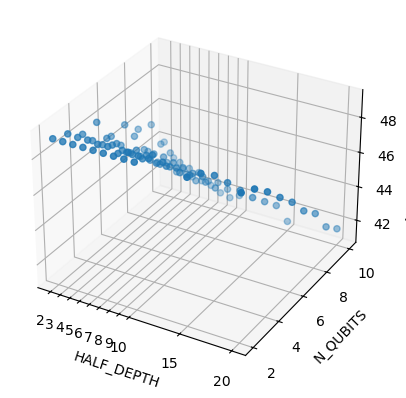

In [110]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

#z = np.concatenate(avg_rewards_over_ep)

x,y = np.meshgrid(x1_axis,x2_axis)

ax.set_xlabel('HALF_DEPTH')
ax.set_ylabel('N_QUBITS')
ax.set_zlabel('Averaged rewards')

plt.xticks(x1_axis, x1_axis)

ax.scatter3D(x, y, avg_rewards_over_ep)

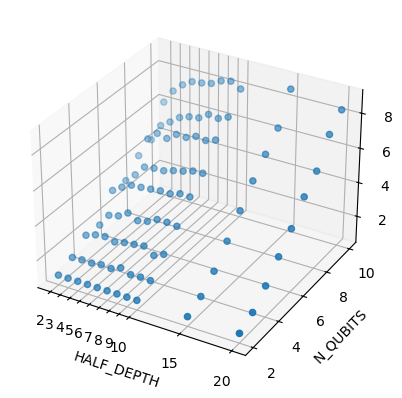

In [93]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

#z = np.concatenate(avg_rewards_over_ep)

x,y = np.meshgrid(x1_axis,x2_axis)

ax.set_xlabel('HALF_DEPTH')
ax.set_ylabel('N_QUBITS')
ax.set_zlabel('Averaged projections')

plt.xticks(x1_axis, x1_axis)

ax.scatter3D(x, y, avg_lens_per_ep_over_ep, linestyle='-', marker='o')

In [ ]:
#write the text files of rewards_list, measurements_list, num_measurements_list, avg_rewards_over_ep, avg_lens_per_ep_over_ep

In [ ]:
#output the text file

In [94]:
#plot
#fitting
#averaged layers
#saturation time
#local measurements and their dynamics

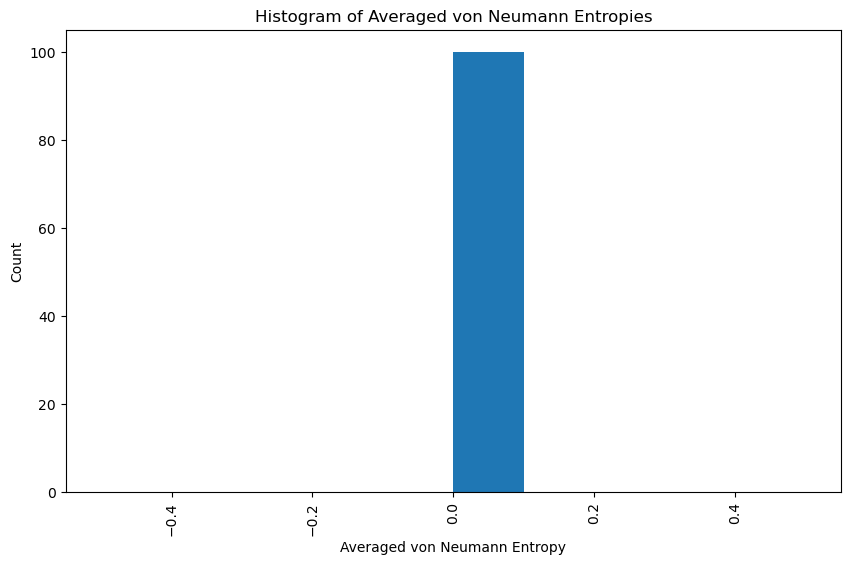

In [116]:
averaged_entropies = []
episodes=1000
for measurement in measurements_list[9][9]:
    entropies = []
    N_QUBITS=N_QUBITS_list[0]
    HALF_DEPTH=HALF_DEPTH_list[0]
    for _ in range(episodes):
        ran_lay=random_layers(N_QUBITS,HALF_DEPTH)
        mea_lay=measure_layers(N_QUBITS,HALF_DEPTH,measurement)
        circ = create_circuit(N_QUBITS,HALF_DEPTH,ran_lay,mea_lay)
        state_initial = pc.stabilizer.zero_state(N_QUBITS)
        state_final = circ.forward(state_initial)
        entropy = averaged_EE(state_final)
        entropies.append(entropy)
        
    
    averaged_entropies.append(np.mean(entropies))

#normalized_averaged_entropies = [float(i)/sum(averaged_entropies) for i in averaged_entropies]
    
plt.figure(figsize=(10,6))
plt.hist(averaged_entropies,density=False)
plt.xlabel('Averaged von Neumann Entropy')
plt.ylabel('Count')
plt.title('Histogram of Averaged von Neumann Entropies')
plt.xticks(rotation=90)
plt.show()

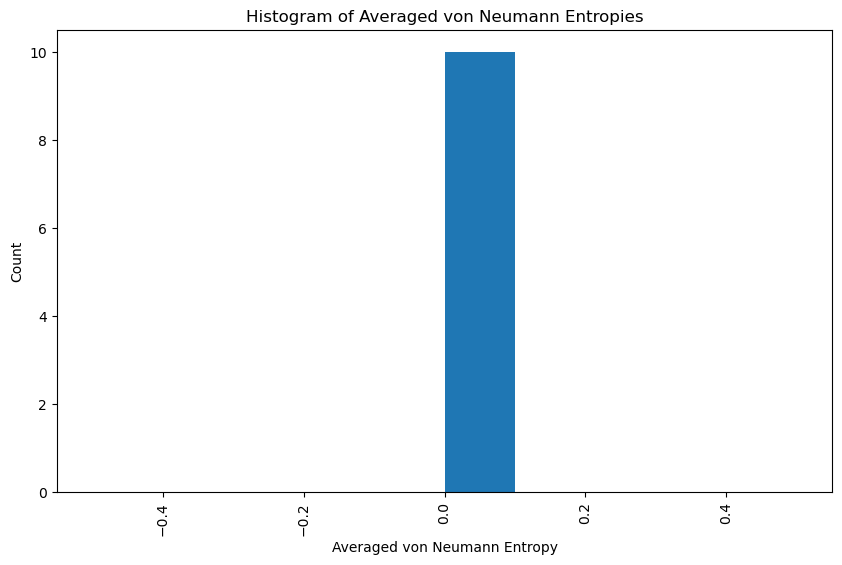

In [107]:
plt.figure(figsize=(10,6))
a,b,c=plt.hist(averaged_entropies, density=True)

plt.xlabel('Averaged von Neumann Entropy')
plt.ylabel('Count')
plt.title('Histogram of Averaged von Neumann Entropies')
plt.xticks(rotation=90)
plt.show()

In [ ]:
normalized_a=[i/sum(a) for i in a]
plt.stairs(normalized_a,b)

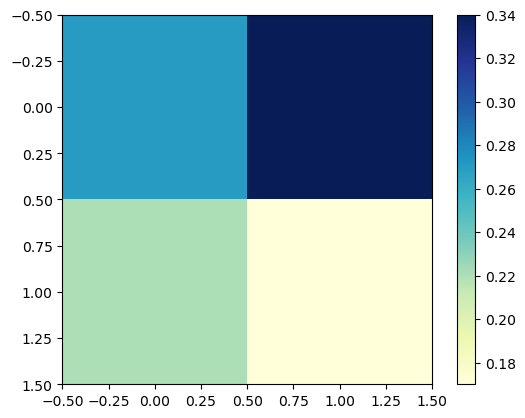

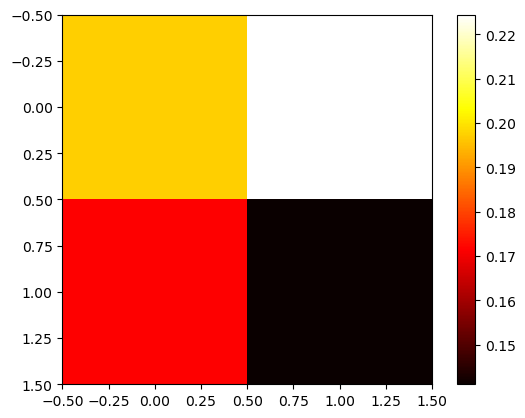

In [108]:
averaged_measurements = np.mean(measurements_list[0][0], axis=0)
variance_measurements = np.var(measurements_list[0][0], axis=0)

plt.figure()
plt.imshow(averaged_measurements, cmap="YlGnBu")
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(variance_measurements, cmap="hot")
plt.colorbar()
plt.show()

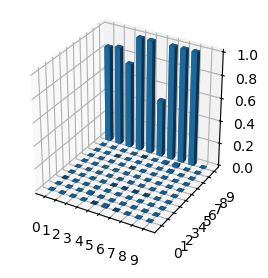

In [128]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(projection='3d')



averaged_measurements = np.mean(measurements_list[8][8], axis=0)
variance_measurements = np.var(measurements_list[8][8], axis=0)

HALF_DEPTH = HALF_DEPTH_list[8]
N_QUBITS = N_QUBITS_list[8]

cord=[[i,j] for i in range(HALF_DEPTH) for j in range (N_QUBITS)]


y=np.transpose([cord[i][0] for i in range (N_QUBITS*HALF_DEPTH)])
x=np.transpose([cord[i][1] for i in range (N_QUBITS*HALF_DEPTH)])
z=np.zeros(N_QUBITS*HALF_DEPTH,int)

width = depth = 0.5

avg_m=[]
for i in range (HALF_DEPTH-1,-1,-1):
    avg_m.append(averaged_measurements[i])
heights=np.concatenate(avg_m)


#plt.xlim(max(x), min(x))

ax.bar3d(x-0.2, y-0.4, z, width, depth, heights, shade=True)
ax.set_box_aspect([int(N_QUBITS/HALF_DEPTH), 1, 1]) 
ax.set_xticks([i for i in range (N_QUBITS)]) 
ax.set_yticks([i for i in range (HALF_DEPTH)]) 

plt.show()

In [ ]:
alpha = [0,0.5,1,4,5]
for aa in alpha:
    x = range(DEPTH)
    y = [penalty(xx,aa) for xx in x]
    plt.plot(x,y)

In [ ]:
theta_star = measurements[0]
theta_star